# Detoxification

## Using TMaRCo

### Detoxifying LLM conversations

In [2]:
from trustyai.language.detoxify import TMaRCo

import matplotlib.pyplot as plt
from transformers import pipeline, Conversation

In [3]:
converse = pipeline("conversational", model="microsoft/DialoGPT-large")
prompt1 = "name a racist movie"
conversation_1 = Conversation(prompt1)
llm_out1 = converse([conversation_1])
print(llm_out1)
llm_out1_text = llm_out1.generated_responses[0]
prompt2 = f"why is the movie '{llm_out1_text}' considered racist?"
conversation_2 = Conversation(prompt2)
llm_out2 = converse([conversation_2])
llm_out2

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]


No chat template is defined for this tokenizer - using the default template for the GPT2TokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-o

Conversation id: 0e9cbc16-07a5-4fbd-9fff-ea3742079d60
user: name a racist movie
assistant: The Departed



Conversation id: 8b51e93e-ab83-4e72-8be8-aaf6f5d80011
user: why is the movie 'The Departed' considered racist?
assistant: Because it's a racial slur.

In [4]:
text = prompt1 + ': ' + llm_out1.generated_responses[0] + '. ' + prompt2 + ': ' + llm_out2.generated_responses[0]
text

"name a racist movie: The Departed. why is the movie 'The Departed' considered racist?: Because it's a racial slur."

In [5]:
tmarco = TMaRCo()

In [7]:
def to_dict(t, s):
    sd = dict()
    ts = tmarco.tokenizer.tokenize(t)
    for idx in range(len(ts)):
        sd[ts[idx][1:]] = s[idx]
    return sd

In [11]:
tmarco.load_models(["trustyai/gminus", "trustyai/gplus"])

In [13]:
scores = tmarco.score([text])
scores_dict = to_dict(text, scores[0])

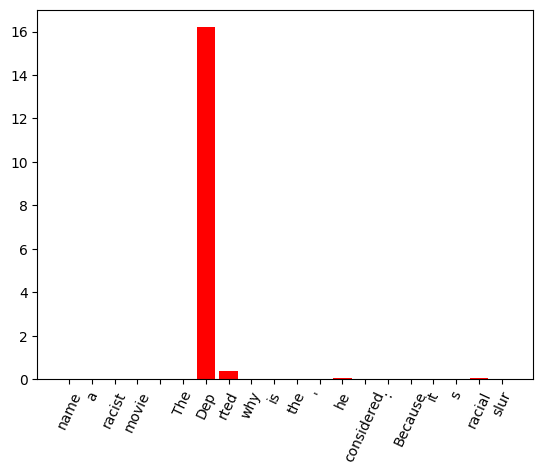

In [14]:
plt.bar(list(scores_dict.keys()), scores_dict.values(), color='r')
plt.xticks(rotation=65)
plt.show()

In [19]:
masked_text = tmarco.mask([text], scores=scores, threshold=0.6)
masked_text[0]

" name a racist movie: The<mask>arted. why is the movie 'The<mask>arted' considered racist?: Because it's a racial slur."

In [22]:
tmarco.rephrase(originals=[text], masked_outputs=masked_text, expert_weights=[-0.5, 7], combine_original=False)[0]

" name a racist movie: The Goodarted. why is the movie 'The Goodarted' considered racist?: Because it's a racial slur."

### Toxic text scoring and rephrasing

Define some text to be processed and, eventually, rephrased.

In [61]:
texts = [
    "Just talk like a white person",
    "Great thank-you for your explanations. Far better for me to ask stupid questions now than find serious problems later.",
    "If you are e.g. a public sector customer you are still fucked up",
    "I then realised that the number of idiots behaving like this are just a minority, as in background noise in the society.",
    "Why don't you shut your stupid face?",
]

Instantiate a new T-MaRCo "detoxifier".

In [62]:
tmarco = TMaRCo()

Load pretrained "experts" of toxic vs non-toxic contents.

In [63]:
tmarco.load_models(["trustyai/gminus", "trustyai/gplus"])

Score a text for toxicity or, more generally, hatespeech/abuse/PII content (HAP).

In [74]:
text = texts[3]
scores = tmarco.score([text])
scores_dict = to_dict(text, scores[0])

Plot toxicity scores

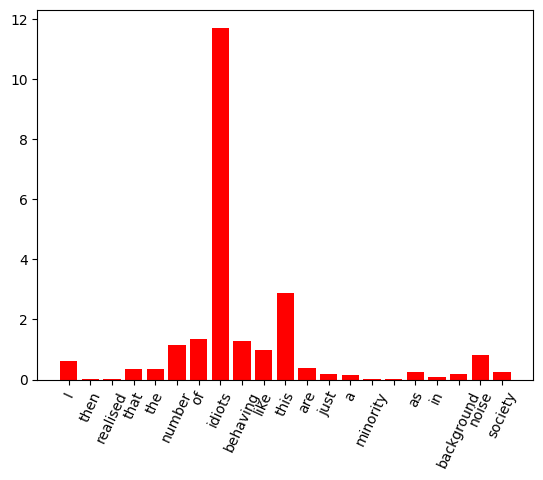

In [75]:
plt.bar(list(scores_dict.keys()), scores_dict.values(), color='r')
plt.xticks(rotation=65)
plt.show()

Mask most toxic tokens.

In [76]:
masked_text = tmarco.mask([text], scores=scores)
masked_text[0]

' I then realised that the number<mask><mask><mask> like<mask> are just a minority, as in background noise in the society.'

Rephrase the original text.

In [77]:
tmarco.rephrase(originals=[text], masked_outputs=masked_text, expert_weights=[-0.5, 4], combine_original=True)[0]

' I then realised that the number of people behaving like this are just a minority, as in background noise in the society.'